In [1]:
#conda create -n tfgpu
#source activate tfgpu
#conda install tensorflow-gpu
#conda install matplotlib
#conda install pillow
#conda install sklearn

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [99]:
import os
import zipfile

rectangle_dir = os.path.join('../generated-data/training/rectangle')
rectangle_files = os.listdir(rectangle_dir)

ellipse_dir = os.path.join('../generated-data/training/ellipse')
ellipse_files = os.listdir(ellipse_dir)

roundrect_dir = os.path.join('../generated-data/training/roundrect')
roundrect_files = os.listdir(roundrect_dir)

print('total training rectangle images:', len(os.listdir(rectangle_dir)))
print('total training ellipse images:', len(os.listdir(ellipse_dir)))
print('total training roundrect images:', len(os.listdir(roundrect_dir)))

total training rectangle images: 100
total training ellipse images: 100
total training roundrect images: 100


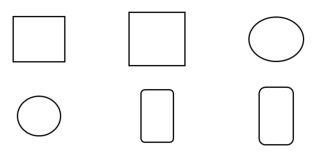

In [100]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rectangle = [os.path.join(rectangle_dir, fname) 
                for fname in rectangle_files[pic_index-2:pic_index]]
next_ellipse = [os.path.join(ellipse_dir, fname) 
                for fname in ellipse_files[pic_index-2:pic_index]]
next_roundrect = [os.path.join(roundrect_dir, fname) 
                for fname in roundrect_files[pic_index-2:pic_index]]

images = enumerate(next_rectangle+next_ellipse+next_roundrect)

for i in range(6):
    plt.subplot(330 + 1 + i)
    _, batch = next(images)
    img = mpimg.imread(batch)
    plt.imshow(img)
    plt.axis('Off')
plt.show()

(150, 150)


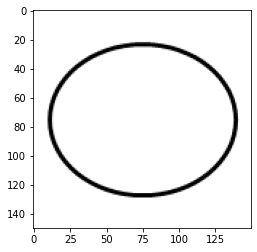

In [101]:
from PIL import Image
import numpy as np

image = Image.open('../generated-data/training/ellipse/0000.png').convert("L")
arr = np.asarray(image)
print(arr.shape)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

In [109]:
TRAINING_DIR = "../generated-data/training/"
training_datagen = ImageDataGenerator(
    rescale = 1./255,  #have pixel value
    rotation_range=10, #Int. Degree range for random rotations
#     width_shift_range=0.8, # Float, 1-D array-like or int - float: fraction of total width, if < 1, or pixels if >= 1
#     height_shift_range=0.8, # Float, 1-D array-like or int - float: fraction of total heigth, if < 1, or pixels if >= 1
#     shear_range=0.2, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
#     zoom_range=0.8,
#     horizontal_flip=False,
#     fill_mode='nearest'
)


# A `DirectoryIterator` yielding tuples of `(x, y)`
# where `x` is a NumPy array containing a batch
# of images with shape `(batch_size, *target_size, channels)`
# and `y` is a NumPy array of corresponding labels.
# that is, in our case 
# x shape:(32, 150, 150, 1)
# y shape:(32, 3)


train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
    color_mode = 'grayscale', # convert to 8bit
	target_size=(150,150),
    class_mode='categorical',
    batch_size=64
)


# x,y = train_generator.next()
# plt.imshow(x[1])
# plt.show()
    
       
VALIDATION_DIR = "../generated-data/validation/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    color_mode = 'grayscale', # convert to 8bit
    target_size=(150,150),
    class_mode='categorical',
    batch_size=64
)

Found 300 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [110]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator, epochs=25, validation_data = validation_generator, steps_per_epoch=20, verbose = 1, validation_steps=3)

model.save("rps.h5")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 15, 15, 128)      

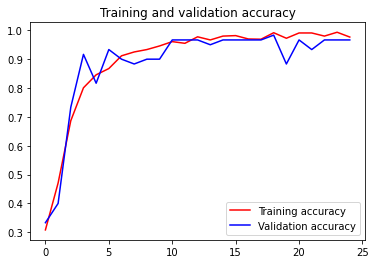

<Figure size 432x288 with 0 Axes>

In [111]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [116]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

bach_size=64
num_of_test_samples=60

Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size +1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

ModuleNotFoundError: No module named 'sklearn'

['ink-ellipse-1.png', 'ink-ellipse-2.png', 'ink-rectangle-1.png', 'ink-roudrect-1.png']
ink-ellipse-1.png


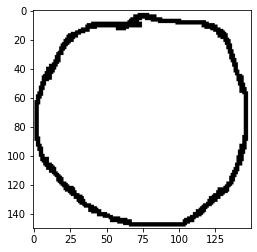

Ellipse: 1.0
ink-ellipse-2.png


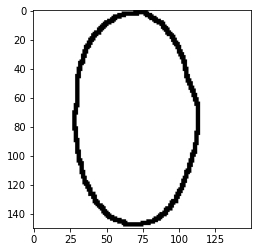

Ellipse: 1.0
ink-rectangle-1.png


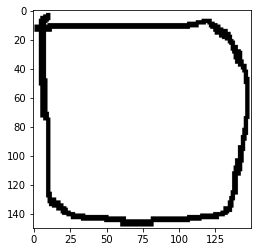

Rectangle: 1.0
ink-roudrect-1.png


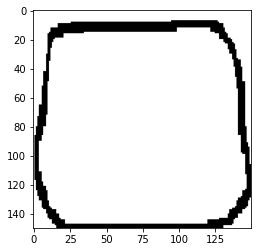

Rounded rect: 1.0


In [137]:
# Test handmade pictures
from keras_preprocessing import image

manual_dir = os.path.join('../manual-data')
manual_files = os.listdir(manual_dir)
print(manual_files)

for manual_file in manual_files:
    print(manual_file)
    img = image.load_img('../manual-data/' + manual_file, target_size=(150, 150))
    plt.imshow(img)
    plt.show()
    img = img.convert("L")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    #     print(classes.shape)
    #     print(classes[0])
    if classes[0][0] > 0 :
        print("Ellipse: " + str(classes[0][0]))
    if classes[0][1] > 0 :
        print("Rectangle: " + str(classes[0][1]))
    if classes[0][2] > 0 :
        print("Rounded rect: " + str(classes[0][2]))

